## SSRO Demo 
## Preprocessing Data Input Tables Site Specific RShiny Demo App
Notes:
- asdf

In [1]:
# working with data
import os
import numpy as np
import pandas as pd
import geopandas as gpd # the library that lets us read in shapefiles
import geoplot as gplt # for plotting maps

# visulizaiton
import seaborn as sns
import matplotlib.pyplot as plt

# Cleanup
from datetime import datetime
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook

In [2]:
# Setting work directory
cwd = os.getcwd()
print("current directory = " + cwd)

os.chdir("../NotEssentialData")
print("new directory = " + os.path.abspath(os.curdir))

current directory = C:\Users\rjame\Documents\WSWC Documents\WaDE Side Projects Local\20221017 Rshiny SS Demo\SSRO_Demo\bonus code
new directory = C:\Users\rjame\Documents\WSWC Documents\WaDE Side Projects Local\20221017 Rshiny SS Demo\SSRO_Demo\NotEssentialData


## Inputs

In [3]:
#Sites Input
fileInput = "Sites.csv"
dfs = pd.read_csv(fileInput)
print(len(dfs))
dfs.head(1)

11287


,SiteUUID,SiteName,SiteNativeID,SiteTypeCV,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,HasRecords
0,COssro_S1011,RIO SOUTH WELL NO 2,1605061,WELL,Well / Pump / Spring / Groundwater Point,-104.858927,37.633941,Observation Site,Groundwater,Annual,Discharge Flow,Discharge Flow,Discharge Flow_Annual_DivTotal_Groundwater,Yes


## Clean Sites Data

In [4]:
# Clean input.  Remove no value sites

dfs = dfs.drop_duplicates() # Drop Duplicate Rows
dfs = dfs.dropna(subset=['VariableSpecificCV']).reset_index(drop=True) # drop no value sites
dfs = dfs.replace(np.nan, "")  # Replaces NaN values with blank.
print(len(dfs))
dfs.head(1)

11018


,SiteUUID,SiteName,SiteNativeID,SiteTypeCV,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,HasRecords
0,COssro_S1011,RIO SOUTH WELL NO 2,1605061,WELL,Well / Pump / Spring / Groundwater Point,-104.858927,37.633941,Observation Site,Groundwater,Annual,Discharge Flow,Discharge Flow,Discharge Flow_Annual_DivTotal_Groundwater,Yes


In [5]:
for x in dfs['VariableCV'].sort_values().unique():
    print(f'"' + x + '",')

"Discharge Flow",
"Reservoir Level",
"Reservoir Storage",


In [6]:
# Fixing blank WaDENameS
def updateWaDENameS(Val):
    Val = str(Val).strip()
    if Val == "" or pd.isnull(Val) or Val == "":
        outString = "Unspecified"
    else:
        outString = Val
    return outString

dfs['WaDENameS'] = dfs.apply(lambda row: updateWaDENameS(row['WaDENameS']), axis=1)
for x in dfs['WaDENameS'].sort_values().unique():
    print(f'"' + x + '",')

"Canal / Ditch / Diversion",
"Reservoir",
"Stream Gage",
"Surface Water Point",
"Unspecified",
"Well / Pump / Spring / Groundwater Point",


In [7]:
# Fixing blank WaDENameWS
def updateWaDENameWS(Val):
    Val = str(Val).strip()
    if Val == "" or pd.isnull(Val) or Val == "":
        outString = "Unspecified"
    else:
        outString = Val
    return outString

dfs['WaDENameWS'] = dfs.apply(lambda row: updateWaDENameWS(row['WaDENameWS']), axis=1)
for x in dfs['WaDENameWS'].sort_values().unique():
    print(f'"' + x + '",')

"Groundwater",
"Surface Water",
"Unspecified",


In [8]:
for x in dfs['TimeStep'].sort_values().unique():
    print(f'"' + x + '",')

"Annual",
"Daily",


In [9]:
# add State field

def createState(Val):
    Val = Val.strip()
    outString = Val[:2]
    return outString

dfs['State'] = dfs.apply(lambda row: createState(row['SiteUUID']), axis=1)
for x in dfs['State'].sort_values().unique():
    print(f'"' + x + '",')

"CO",
"ID",
"MT",
"NE",
"NV",
"OR",
"TX",


In [10]:
# Groupby SiteUUID
dfs = dfs.groupby(['SiteUUID']).agg(lambda x: ", ".join([str(elem) for elem in (list(set(x))) if elem!=""])).replace(np.nan, "").reset_index()
print(len(dfs))
dfs.head(1)

10879


,SiteUUID,SiteName,SiteNativeID,SiteTypeCV,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,HasRecords,State
0,COssro_S1,MIDDLEMIST DITCH 2,100539,DITCH,Canal / Ditch / Diversion,-103.731685,39.491687,Observation Site,Surface Water,Annual,Discharge Flow,Discharge Flow,Discharge Flow_Annual_DivTotal_Surface Water,Yes,CO


In [11]:
# count num of VariableSpecificCV after groupby

def countNumVar(Val):
    Val = list(Val.split(","))
    if Val == [""]:
        ValLen = 0
    else:
        ValLen = len(Val)
    return ValLen

dfs['CountVar'] = dfs.apply(lambda row: countNumVar(row['VariableSpecificCV']), axis=1)
for x in dfs['CountVar'].sort_values().unique():
    print(f'"' + str(x) + '",')

"1",
"2",


In [12]:
# attach timeframe based on SiteUUID

fileInput = "start_end_Sites.csv"
dfstf = pd.read_csv(fileInput)
dfs = pd.merge(dfs, dfstf, on='SiteUUID', how='left')
print(len(dfs))
dfs.head(1)

10879


,SiteUUID,SiteName,SiteNativeID,SiteTypeCV,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,HasRecords,State,CountVar,minTimeFrameStart,maxTimeFrameEnd
0,COssro_S1,MIDDLEMIST DITCH 2,100539,DITCH,Canal / Ditch / Diversion,-103.731685,39.491687,Observation Site,Surface Water,Annual,Discharge Flow,Discharge Flow,Discharge Flow_Annual_DivTotal_Surface Water,Yes,CO,1,2007-01-01,2007-12-31


In [13]:
# Temp Fix

# remove lat & long entries that contain a ','
dfs = dfs[dfs['Latitude'].str.contains(',') == False]
dfs = dfs[dfs['Longitude'].str.contains(',') == False]

# Ensure long is < 0 and > -125 (few ID sites out of bounds)
# Ensure lat is > 10 and < 50 (few MT sites out of bounds).
dfs['Latitude'] = pd.to_numeric(dfs['Latitude'], errors='coerce')
dfs['Longitude'] = pd.to_numeric(dfs['Longitude'], errors='coerce')
dfs = dfs[(dfs['Latitude'].astype(int) > 10) & (dfs['Latitude'].astype(int) < 50)]
dfs = dfs[(dfs['Longitude'].astype(int) < 0) & (dfs['Longitude'].astype(int) > -125)]

print(len(dfs))
dfs.head(1)

10879


,SiteUUID,SiteName,SiteNativeID,SiteTypeCV,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,HasRecords,State,CountVar,minTimeFrameStart,maxTimeFrameEnd
0,COssro_S1,MIDDLEMIST DITCH 2,100539,DITCH,Canal / Ditch / Diversion,-103.731685,39.491687,Observation Site,Surface Water,Annual,Discharge Flow,Discharge Flow,Discharge Flow_Annual_DivTotal_Surface Water,Yes,CO,1,2007-01-01,2007-12-31


In [14]:
#Inspect output
dfs

,SiteUUID,SiteName,SiteNativeID,SiteTypeCV,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,HasRecords,State,CountVar,minTimeFrameStart,maxTimeFrameEnd
0,COssro_S1,MIDDLEMIST DITCH 2,100539,DITCH,Canal / Ditch / Diversion,-103.731685,39.491687,Observation Site,Surface Water,Annual,Discharge Flow,Discharge Flow,Discharge Flow_Annual_DivTotal_Surface Water,Yes,CO,1,2007-01-01,2007-12-31
1,COssro_S10,CAROLINE EPPLE DITCH 2,100594,DITCH,Canal / Ditch / Diversion,-104.237442,40.038835,Observation Site,Surface Water,Annual,Discharge Flow,Discharge Flow,Discharge Flow_Annual_DivTotal_Surface Water,Yes,CO,1,1997-01-01,1997-12-31
2,COssro_S100,REXFORD DITCH,200501,DITCH,Canal / Ditch / Diversion,-104.658766,40.334251,Observation Site,Surface Water,Annual,Discharge Flow,Discharge Flow,Discharge Flow_Annual_DivTotal_Surface Water,Yes,CO,1,1982-01-01,2011-12-31
3,COssro_S1000,PETRIE POND,1603309,RESERVOIR,Reservoir,-104.995757,37.477811,Observation Site,Surface Water,Annual,Discharge Flow,Discharge Flow,Discharge Flow_Annual_DivTotal_Surface Water,Yes,CO,1,2011-01-01,2020-12-31
4,COssro_S1001,ANDREATTA RESERVOIR NO 1,1603500,RESERVOIR,Reservoir,-104.884402,37.485299,Observation Site,Surface Water,Annual,Discharge Flow,Discharge Flow,Discharge Flow_Annual_DivTotal_Surface Water,Yes,CO,1,2011-01-01,2020-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10874,TXssro_S95,Medina,WaDETX_S74,Reservoir,Reservoir,-98.933922,29.540230,Observation Site,Surface Water,Daily,"Reservoir Level, Reservoir Storage","Reservoir Level, Reservoir Storage","Reservoir Storage_Daily_Storage_Surface Water,...",Yes,TX,2,1997-08-09,2022-12-20
10875,TXssro_S96,Meredith,WaDETX_S75,Reservoir,Reservoir,-101.551285,35.710598,Observation Site,Surface Water,Daily,"Reservoir Level, Reservoir Storage","Reservoir Level, Reservoir Storage","Reservoir Storage_Daily_Storage_Surface Water,...",Yes,TX,2,1986-10-02,2022-12-20
10876,TXssro_S97,Millers Creek,WaDETX_S76,Reservoir,Reservoir,-99.388969,33.408985,Observation Site,Surface Water,Daily,"Reservoir Level, Reservoir Storage","Reservoir Level, Reservoir Storage","Reservoir Storage_Daily_Storage_Surface Water,...",Yes,TX,2,1976-10-02,2022-12-20
10877,TXssro_S98,Mineral Wells,WaDETX_S77,Reservoir,Reservoir,-98.041985,32.816795,Observation Site,Surface Water,Daily,"Reservoir Level, Reservoir Storage","Reservoir Level, Reservoir Storage","Reservoir Storage_Daily_Storage_Surface Water,...",Yes,TX,2,1999-02-19,2022-12-20


In [15]:
# Exporting output files.
dfs.to_excel('Sites_v2.xlsx', index=False)

## Mapping to Validate Sites

<AxesSubplot:>

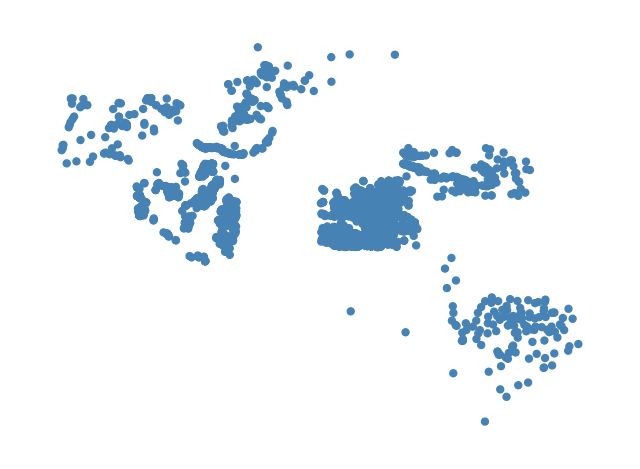

In [16]:
# map points
# convert dataframe to geodataframe
gdf_sites = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.Longitude.astype(float), dfs.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdf_sites)

In [17]:
dftemp = dfs[dfs['State'] == 'OR'].copy()
print(len(dftemp))
dftemp.head(1)

97


,SiteUUID,SiteName,SiteNativeID,SiteTypeCV,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,TimeStep,VariableCV,WaDENameV,VariableSpecificCV,HasRecords,State,CountVar,minTimeFrameStart,maxTimeFrameEnd,geometry
10660,ORssro_S1,"BUCK CR AB PAULINA MARSH NR SILVER LAKE, OR",10391050,Stream,Stream Gage,-121.134564,43.142203,Observation Site,Unspecified,Daily,Discharge Flow,Discharge Flow,Discharge Flow_Daily_Unspecified_Surface Water,Yes,OR,1,1989-03-01,2014-09-30,POINT (-121.13456 43.14220)
